In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 18.4MB 51kB/s 


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [20]:
#1.Load DataSet with Pandas
df_train = pd.read_csv('/resources/data/forecast/yds_train2018.csv');
df_test = pd.read_csv('/resources/data/forecast/yds_test2018.csv');
df_test = df_test.drop(['Sales'], axis=1)
df_promotional = pd.read_csv('/resources/data/forecast/promotional_expense.csv');
df_holiday = pd.read_csv('/resources/data/forecast/holidays.csv')

In [21]:
#2.Insert Valuable Data to Training Set
X = df_train[['Year','Month','Product_ID','Country','Sales']]

#3.Summation of Sales Column
X = X.groupby(['Year','Month','Product_ID','Country'], as_index=False).sum()

#4.Target Variable
Y = X['Sales']

In [22]:
#6.Insert Valuable Data to Test Set
X_test = df_test[['Year','Month','Product_ID','Country']]

In [23]:
#7.Merge the Expense Column to Train and Test Data
X = X.merge(df_promotional, left_on=['Year','Month','Product_ID','Country'], right_on=['Year','Month','Product_ID','Country'], how='left')
X_test = X_test.merge(df_promotional, left_on=['Year','Month','Product_ID','Country'], right_on=['Year','Month','Product_ID','Country'], how='left')

In [24]:
#7.Find Missing Values
missing_data = X.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

missing_data = X_test.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 


Year
False    388
Name: Year, dtype: int64

Month
False    388
Name: Month, dtype: int64

Product_ID
False    388
Name: Product_ID, dtype: int64

Country
False    388
Name: Country, dtype: int64

Sales
False    388
Name: Sales, dtype: int64

Expense_Price
False    336
True      52
Name: Expense_Price, dtype: int64

Year
False    105
Name: Year, dtype: int64

Month
False    105
Name: Month, dtype: int64

Product_ID
False    105
Name: Product_ID, dtype: int64

Country
False    105
Name: Country, dtype: int64

Expense_Price
False    99
True      6
Name: Expense_Price, dtype: int64



In [25]:
#8.Find the Average value of Expense
avg = X.groupby(['Country'], as_index=False).mean()
avg_1 = X_test.groupby(['Country'], as_index=False).mean()

In [26]:
#9.Add the mean value of Expense to Expense Null Values    
array_columbia = np.array([186,196,206,216,227,238,249,260,271,282,293,304,315,326,337,345,353,361,369,
                  371,373,375,377,379,381,383,385,387])

array_argentina = np.array([386,384,382,380,378,376,374,372,370,368,360,352,344,336,325,
                            314,303,292,281,270,259,248,237,226])    

X.iloc[array_argentina, X.columns.get_loc('Expense_Price')] = 8222.515128205128
X.iloc[array_columbia, X.columns.get_loc('Expense_Price')] = 2210.50158974359

test_columbia = [63,64,65]
test_argentina = [24,25,26]

X_test.iloc[test_argentina, X_test.columns.get_loc('Expense_Price')] = 8222.515128205128
X_test.iloc[test_columbia, X_test.columns.get_loc('Expense_Price')] = 2210.50158974359

In [27]:
#10.Add Holidays Column to Train and Test Column
sLength = len(X['Month'])
X['Holiday'] = pd.Series(np.random.randn(sLength), index=X.index)

sLength_test = len(X_test['Month'])
X_test['Holiday'] = pd.Series(np.random.randn(sLength_test), index=X_test.index)

In [28]:
def fetch_holidays(dataframe):   
    count_of_holidays = []
    for index, row  in dataframe.iterrows():
        holidays_entry = []
        try:
            holidays_entry.append(df_holiday.loc[(df_holiday.Country == row['Country']) & (df_holiday.Year == row['Year']) & (df_holiday.Month == row['Month']),'Holiday'])
            count_of_holidays.append(len(holidays_entry[0]))
        except IndexError:
            count_of_holidays.append(len(holidays_entry[0]))
       
    dataframe['Holiday']=count_of_holidays


df_holiday['Date']  = pd.to_datetime(df_holiday['Date'])
df_holiday['Year'] = pd.DatetimeIndex(df_holiday['Date']).year
df_holiday['Month'] = pd.DatetimeIndex(df_holiday['Date']).month
df_holiday = df_holiday.drop(df_holiday.columns[0], axis=1)


fetch_holidays(X)
fetch_holidays(X_test)

In [29]:
#Explanatory Data Analysis

#11. find categorical variables
categorical = [var for var in X.columns if X[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

#12.find numerical variables
numerical = [var for var in X.columns if X[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 1 categorical variables
There are 6 numerical variables


In [30]:
#13.let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(X[var].unique())<20:
        print(var, ' values: ', X[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

Year  values:  [2013 2014 2015 2016]
Month  values:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
Product_ID  values:  [1 2 4 5 3]
Holiday  values:  [1 2 0 4 3]
There are 4 discrete variables


In [31]:
#14.first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['Sales']]
continuous

['Expense_Price']

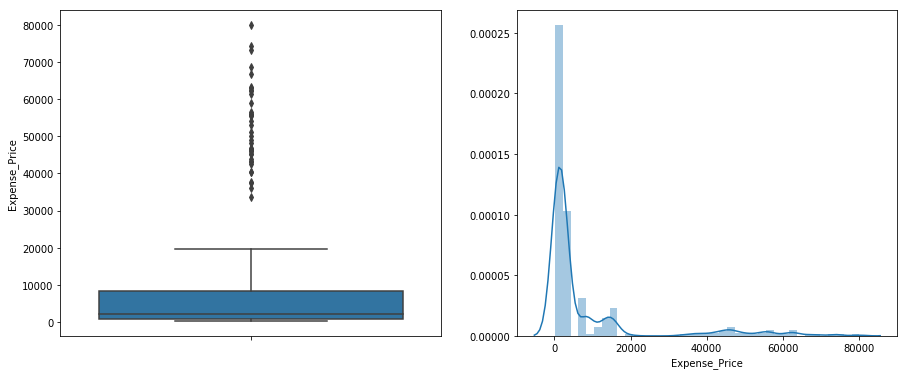

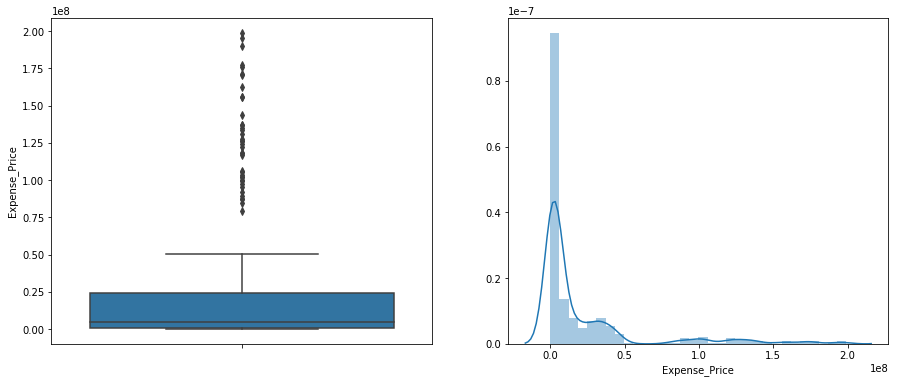

In [32]:
for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=X[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(X[var].dropna())
    fig.set_xlabel(var)

    plt.show()


#16.let's look at the distribution of the target variable
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=X['Sales'])
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(X['Sales'].dropna())
fig.set_xlabel(var)
plt.show()

In [33]:

#17.check outlies in discrete variables
for var in discrete:
    print(X[var].value_counts() / np.float(len(X)))



#18.check if our categorical variables have a huge number of categories
for var in categorical:
    print(var, ' contains ', len(X[var].unique()), ' labels')



#19.Let's separate into train and test set
train, test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)
train.shape, test.shape


2015    0.324742
2014    0.288660
2013    0.278351
2016    0.108247
Name: Year, dtype: float64
3     0.095361
2     0.095361
1     0.095361
10    0.082474
9     0.082474
8     0.079897
7     0.079897
6     0.079897
5     0.079897
4     0.079897
12    0.074742
11    0.074742
Name: Month, dtype: float64
2    0.402062
1    0.201031
4    0.175258
3    0.134021
5    0.087629
Name: Product_ID, dtype: float64
0    0.322165
2    0.293814
1    0.286082
3    0.067010
4    0.030928
Name: Holiday, dtype: float64
Country  contains  6  labels


((310, 7), (78, 7))

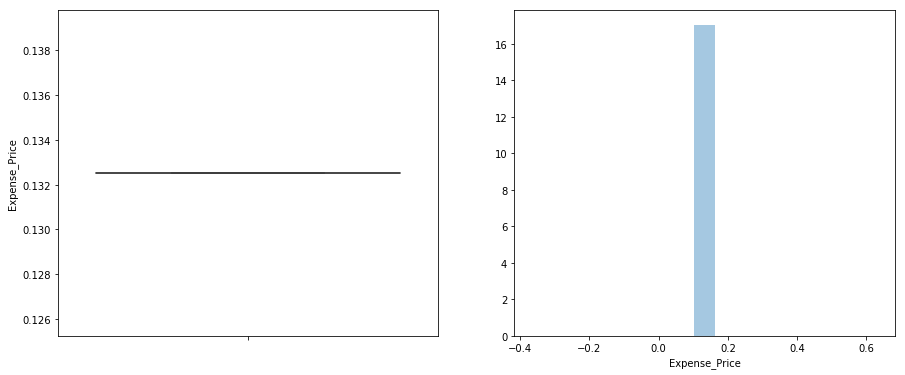

In [34]:
#20.Transformation of Numerical variables
#As most variables were skewed, I will transform them with the box cox transformation
def boxcox_transformation(var):
    train[var], param = stats.boxcox(train[var]+1) 
    test[var], param = stats.boxcox(test[var]+1) 
    X_test[var], param = stats.boxcox(X_test[var]+1) 



#21. let's  check if the transformation created infinite values
for var in continuous:
    boxcox_transformation(var)
    
train[continuous].head()

for var in continuous:
    if np.isinf(train[var]).sum()>1:
        print(var)

for var in continuous:
    if np.isinf(test[var]).sum()>1:
        print(var)

for var in continuous:
    if np.isinf(X_test[var]).sum()>1:
        print(var)


for var in train.columns:
    if test[var].isnull().sum()>0:
        print(var, test[var].isnull().sum())




#22. let's make boxplots to visualise outliers in the continuous variables
# and histograms to get an idea of the distribution
# hopefully the transformation yielded variables more "Gaussian"looking
for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=train[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(train[var].dropna())
    fig.set_xlabel(var)

    plt.show()

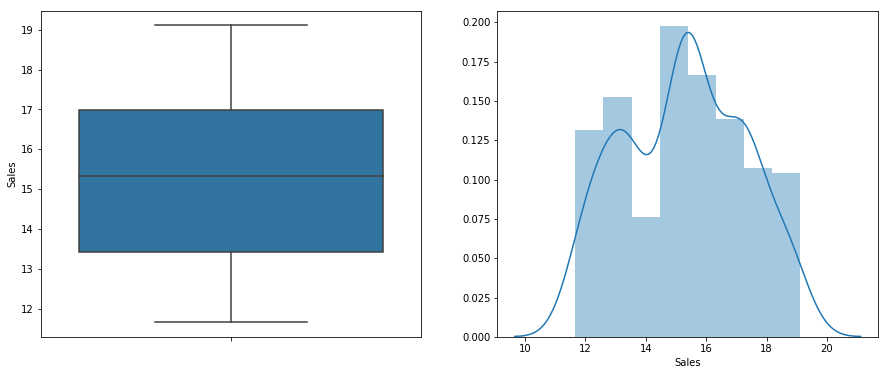

In [35]:
var = 'Sales'
y_train = np.log(y_train) 
y_test = np.log(y_test) 

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(y_train)#.hist(bins=20)
fig.set_xlabel(var)
plt.show()

In [36]:
#24.Encode categorical variables
labelencoder_X = LabelEncoder()
test['Country'] = labelencoder_X.fit_transform(test['Country'])
train['Country'] = labelencoder_X.fit_transform(train['Country'])
X_test['Country'] = labelencoder_X.fit_transform(X_test['Country'])

In [37]:
#5.Drop Target Column from Train Data
X = X.drop(['Sales'], axis=1)

In [38]:
train.dtypes

Year               int64
Month              int64
Product_ID         int64
Country            int64
Sales            float64
Expense_Price    float64
Holiday            int64
dtype: object

In [39]:
#5.Drop Target Column from Train Data
train = train.drop(['Sales'], axis=1)

In [40]:
#5.Drop Target Column from Train Data
test = test.drop(['Sales'], axis=1)

In [41]:
#25.lets explore train dataset        
train.head()

training_vars = [var for var in train.columns if var not in ['Sales']]

In [42]:
#26 fit scaler
scaler = StandardScaler() # create an instance
scaler.fit(test[training_vars])
scaler.fit(train[training_vars])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [43]:
#.Machine Learning Modeling Part

#27.XGB Regressor Modeling 
xgb_model = XGBRegressor()
from sklearn.metrics import mean_squared_error
eval_set = [(test[training_vars], y_test)]
xgb_model.fit(train[training_vars], y_train, eval_set=eval_set, verbose=False)

pred = xgb_model.predict(train[training_vars])

In [44]:
#28.Calculating Root Mean Square error
print('xgb train mse: {}'.format(mean_squared_error(y_train, pred)))
pred = xgb_model.predict(test[training_vars])
print('xgb test mse: {}'.format(mean_squared_error(y_test, pred)))

xgb train mse: 0.10662117013156995
xgb test mse: 0.24781372989026237


In [45]:
#29.check SMAPE
def smape(A, F):
    return (100/len(A)) * np.sum(2 * (np.abs(F - A) / (np.abs(A) + np.abs(F))))
LB = smape(np.exp(y_test.values),np.exp(pred))
print(2-(LB/100))

1.7381287532309129


In [46]:
#30.Calculate r2 score
print(r2_score(np.exp(y_test.values),np.exp(pred))) 


#31.Prediction
pred_ls = []
pred_ls.append(pd.Series(xgb_model.predict(X_test[training_vars])))


#32.inverse log transform
final_pred = np.exp(pd.concat(pred_ls, axis=1).mean(axis=1))

0.9310057234727329


In [47]:
#33.Output File
output = pd.DataFrame({'S_No': df_test['S_No'],'Year':df_test['Year'], 'Month':df_test['Month'], 'Product_ID':df_test['Product_ID'],
                       'Country':df_test['Country'], 'Sales':final_pred})

#34. write Model File to csv    
output.to_csv('yds_submission2018.csv',index=False) 